In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import os
module_path = os.path.abspath(os.path.join("..", "archstyle"))
sys.path.append(module_path)


Transfer Learning for Computer Vision Tutorial
==============================================

> In practice, very few people train an entire Convolutional Network
> from scratch (with random initialization), because it is relatively
> rare to have a dataset of sufficient size. Instead, it is common to
> pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
> contains 1.2 million images with 1000 categories), and then use the
> ConvNet either as an initialization or a fixed feature extractor for
> the task of interest.

These two major transfer learning scenarios look as follows:

-   **Finetuning the ConvNet**: Instead of random initialization, we
    initialize the network with a pretrained network, like the one that
    is trained on imagenet 1000 dataset. Rest of the training looks as
    usual.
-   **ConvNet as fixed feature extractor**: Here, we will freeze the
    weights for all of the network except that of the final fully
    connected layer. This last fully connected layer is replaced with a
    new one with random weights and only this layer is trained.


In [3]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os

cudnn.benchmark = True

Load Data
=========

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we\'re going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants
and bees. There are 75 validation images for each class. Usually, this
is a very small dataset to generalize upon, if trained from scratch.
Since we are using transfer learning, we should be able to generalize
reasonably well.

This dataset is a very small subset of imagenet.


In [4]:
from torchvision.models import ResNet34_Weights
from torchvision.models import EfficientNet_B0_Weights

# weights = ResNet34_Weights.DEFAULT
weights = EfficientNet_B0_Weights.DEFAULT
categories = weights.meta["categories"]

# default transforms from pretrained model, we are not using data augmentation here
preprocess = weights.transforms()

data_transforms = {
    'train': preprocess,
    'val': preprocess,
    'test': preprocess
}

data_dir = "../data/preprocess"

batch_size = 4
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
print(len(class_names))

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

5
Using cuda device


In [4]:
dataset_sizes

{'train': 38, 'val': 19, 'test': 38}

In [5]:
len(dataloaders["train"].dataset), len(dataloaders["val"].dataset)

(38, 19)

Finetuning the ConvNet
======================

Load a pretrained model and reset final fully connected layer.


In [6]:
from train import train_model

# model_ft = models.resnet34(weights=weights)
model_ft = models.efficientnet_b0(weights=weights)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /home/alberto/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 50.6MB/s]


In [7]:
model_ft

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [8]:
model_ft.classifier[1].in_features

1280

In [9]:
# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, len(class_names))

num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, len(class_names))

Train and evaluate
==================

It should take around 15-25 min on CPU. On GPU though, it takes less
than a minute.


In [10]:
model_ft, hist = train_model(model_ft, dataloaders, num_epochs=15)


Epoch 0/14
----------
train Loss: 1.5917 Acc: 0.1842
val Loss: 1.5574 Acc: 0.3684

Epoch 1/14
----------
train Loss: 1.5137 Acc: 0.3684
val Loss: 1.4873 Acc: 0.4737

Epoch 2/14
----------
train Loss: 1.3962 Acc: 0.5526
val Loss: 1.4393 Acc: 0.5789

Epoch 3/14
----------
train Loss: 1.2342 Acc: 0.7632
val Loss: 1.3838 Acc: 0.5263

Epoch 4/14
----------
train Loss: 1.1059 Acc: 0.8158
val Loss: 1.3389 Acc: 0.5789

Epoch 5/14
----------
train Loss: 1.1509 Acc: 0.6579
val Loss: 1.2893 Acc: 0.5789

Epoch 6/14
----------
train Loss: 1.0214 Acc: 0.8158
val Loss: 1.2739 Acc: 0.6316

Epoch 7/14
----------
train Loss: 0.9237 Acc: 0.8684
val Loss: 1.2554 Acc: 0.6842

Epoch 8/14
----------
train Loss: 0.9770 Acc: 0.8158
val Loss: 1.2632 Acc: 0.6316

Epoch 9/14
----------
train Loss: 0.8291 Acc: 0.8947
val Loss: 1.2661 Acc: 0.6842

Epoch 10/14
----------
train Loss: 0.8595 Acc: 0.9211
val Loss: 1.2708 Acc: 0.6316

Epoch 11/14
----------
train Loss: 0.7871 Acc: 1.0000
val Loss: 1.2575 Acc: 0.6316

Ep

In [11]:
# from dl.cv_project.archstyle.visualization import plot_hist
# plot_hist(hist)

Inference on custom images
==========================

Use the trained model to make predictions on custom images and visualize
the predicted class labels along with the images.


Output shape: torch.Size([1, 5])
Predictions shape: torch.Size([1]) 


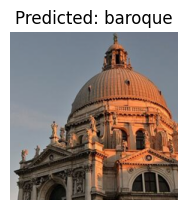

In [12]:
from visualization import visualize_model_predictions

visualize_model_predictions(
    model_ft,
    preprocess, class_names,
    img_path="../data/preprocess/test/baroque/hector_03_baroque.jpg"
)

plt.show()

Output shape: torch.Size([1, 5])
Predictions shape: torch.Size([1]) 


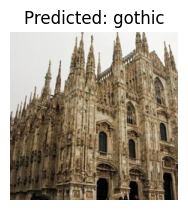

In [13]:
visualize_model_predictions(
    model_ft,
    preprocess, class_names,
    img_path="../data/preprocess/test/gothic/irina_03_gothic.jpg"
)

plt.show()

In [14]:
from train import evaluate

evaluate(model_ft, dataloaders["test"])

Accuracy: 0.8421
Total:  38
Correct:  32.0


In [15]:
evaluate(model_ft, dataloaders["train"])
evaluate(model_ft, dataloaders["val"])


Accuracy: 1.0000
Total:  38
Correct:  38.0
Accuracy: 0.6842
Total:  19
Correct:  13.0


In [16]:
# outputs = torch.tensor([[0.1, 0.3, 0.8, 0.2, 0.1],
#                         [0.9, 0.2, 0.1, 0.3, 0.05],
#                         [0.2, 0.1, 0.3, 0.7, 0.4]])
# max_values, max_indices = torch.max(outputs, dim=1)
#
# print(max_values)
# print(max_indices)

In [17]:
# def print_gpu_memory():
#     print("-" * 40)
#     print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
#     print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")
#     print("-" * 40)

# import gc
# del model_ft
#
# print_gpu_memory()
# torch.cuda.empty_cache()
# print_gpu_memory()
# gc.collect()
# torch.cuda.empty_cache()
# print_gpu_memory()

## we are missing optimizer here, we could pass the optimizer to train_model and release it

In [18]:
torch.save(model_ft.state_dict(), "../models/model.pth")

In [19]:
model_ft.load_state_dict(torch.load("../models/model.pth", weights_only=True))

evaluate(model_ft, dataloaders["test"])

Accuracy: 0.8421
Total:  38
Correct:  32.0
